## Training VAE Autoencoder with ignition events (1)

**Status:** PUBLIC Distribution <br>
**File Name:** 01_Autoencoder_training_ignition_events(1).ipynb

**Author:** Jaume Manero / Darshana Upadhyay / Richard Purcell<br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

This version uses StandardScaling

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Hyperparameters



In [3]:
path_ignition = './Data/ignition_rows.csv'
path_non_ignition = './Data/non_ignition_rows.csv'
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=1000000)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [4]:
non_ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [5]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)
non_ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [6]:
# we create a numpy array with the features of every row
ignition_np = ignition_df.to_numpy()
print('ignition shape',ignition_np.shape)
non_ignition_np = non_ignition_df.to_numpy()
print('non_ignition shape',non_ignition_np.shape)

ignition shape (51918, 22)
non_ignition shape (1000000, 22)


In [7]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = PowerTransformer()
ignition_scaled = scaler.fit_transform(ignition_df)
ignition_scaled.shape

/home/manero/DL/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


(51918, 22)

In [8]:
non_ignition_df = non_ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = PowerTransformer()
non_ignition_scaled = scaler.fit_transform(non_ignition_df)
non_ignition_scaled.shape

(1000000, 22)

In [9]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]
X_train.shape

(41534, 22)

In [10]:
# generate non-ignition set
# test will be only non-ignition data (much larger)

len_non_ignition = len(non_ignition_scaled)
X_test = non_ignition_scaled
X_test.shape

(1000000, 22)

In [11]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

1653


In [12]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_test)))
X_test = np.nan_to_num(X_test)
# y_test.shape

1988597


In [13]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(np.abs(v1 - v2), axis=1)

In [14]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 4)
intermediate_dim = 32
latent_dim = 4

In [16]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 22)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           736         ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 16)           528         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           272         ['dense_1[0][0]']                
                                                                                            

In [17]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim/2, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim, activation='relu')(x)
x             = Dense(intermediate_dim, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 22)                726       
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


In [18]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [19]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 22)]              0         
                                                                 
 encoder (Functional)        (None, 4)                 1672      
                                                                 
 decoder (Functional)        (None, 22)                2406      
                                                                 
Total params: 4,078
Trainable params: 4,078
Non-trainable params: 0
_________________________________________________________________
Train on 41534 samples
Epoch 1/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 2775.3317
Epoch 2/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 2399.2613
Epoch 3/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 2260.1055
Epoch 4/5000
41534/

41534/41534 [==============================] - 1s 13us/sample - loss: 1852.2544
Epoch 166/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1851.6192
Epoch 167/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1851.0371
Epoch 168/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1851.9132
Epoch 169/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1849.9463
Epoch 170/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1849.7727
Epoch 171/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1849.6777
Epoch 172/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1850.3922
Epoch 173/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1849.0627
Epoch 174/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1849.0335
Epoch 175/5000
41534/41534 [==============================] - 0s 

41534/41534 [==============================] - 0s 11us/sample - loss: 1843.5296
Epoch 338/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1843.7287
Epoch 339/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1843.9567
Epoch 340/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1841.9815
Epoch 341/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1841.9248
Epoch 342/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1842.6758
Epoch 343/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1841.2098
Epoch 344/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1841.4997
Epoch 345/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1841.5084
Epoch 346/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1841.1889
Epoch 347/5000
41534/41534 [==============================] - 0s 

41534/41534 [==============================] - 0s 12us/sample - loss: 1842.8193
Epoch 510/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1840.8828
Epoch 511/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1840.0397
Epoch 512/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1840.3488
Epoch 513/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1841.4074
Epoch 514/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1840.1158
Epoch 515/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1840.3213
Epoch 516/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1839.2368
Epoch 517/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1838.9262
Epoch 518/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1838.7703
Epoch 519/5000
41534/41534 [==============================] - 0s 

41534/41534 [==============================] - 1s 15us/sample - loss: 1837.1304
Epoch 682/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1835.2859
Epoch 683/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1836.1715
Epoch 684/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1835.6087
Epoch 685/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1838.9771
Epoch 686/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1839.4048
Epoch 687/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1838.5235
Epoch 688/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1839.6085
Epoch 689/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1841.6608
Epoch 690/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1840.2616
Epoch 691/5000
41534/41534 [==============================] - 1s 

41534/41534 [==============================] - 0s 12us/sample - loss: 1830.0589
Epoch 854/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1829.4608
Epoch 855/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1829.3193
Epoch 856/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1828.8627
Epoch 857/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1829.4422
Epoch 858/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1829.7090
Epoch 859/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1830.7119
Epoch 860/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1832.8378
Epoch 861/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1833.5227
Epoch 862/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1833.4106
Epoch 863/5000
41534/41534 [==============================] - 0s 

41534/41534 [==============================] - 0s 10us/sample - loss: 1821.1759
Epoch 1026/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1822.3771
Epoch 1027/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1823.0430
Epoch 1028/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1822.4892
Epoch 1029/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1822.4527
Epoch 1030/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1823.3979
Epoch 1031/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1822.6799
Epoch 1032/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1822.2079
Epoch 1033/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1822.8165
Epoch 1034/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1822.5921
Epoch 1035/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 11us/sample - loss: 1818.9853
Epoch 1196/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1817.8511
Epoch 1197/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1816.5161
Epoch 1198/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1817.6465
Epoch 1199/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1816.0576
Epoch 1200/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1815.7037
Epoch 1201/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1815.8331
Epoch 1202/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1816.9363
Epoch 1203/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1817.1786
Epoch 1204/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1818.6455
Epoch 1205/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 13us/sample - loss: 1812.6723
Epoch 1366/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1813.0793
Epoch 1367/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1812.6429
Epoch 1368/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1812.7704
Epoch 1369/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1812.0282
Epoch 1370/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1811.6367
Epoch 1371/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1811.9102
Epoch 1372/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1812.5557
Epoch 1373/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1811.3844
Epoch 1374/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1811.3418
Epoch 1375/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 11us/sample - loss: 1814.7835
Epoch 1536/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1819.7101
Epoch 1537/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1817.3136
Epoch 1538/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1814.6031
Epoch 1539/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1812.7819
Epoch 1540/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1812.5079
Epoch 1541/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1811.1982
Epoch 1542/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1811.5190
Epoch 1543/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1811.7760
Epoch 1544/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1810.9447
Epoch 1545/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 12us/sample - loss: 1804.8320
Epoch 1706/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1804.4988
Epoch 1707/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.7912
Epoch 1708/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.5308
Epoch 1709/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1804.4667
Epoch 1710/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1805.0147
Epoch 1711/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1806.5018
Epoch 1712/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1806.1969
Epoch 1713/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1807.3884
Epoch 1714/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1808.3532
Epoch 1715/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 12us/sample - loss: 1803.2999
Epoch 1876/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1802.7369
Epoch 1877/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1804.8057
Epoch 1878/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.4765
Epoch 1879/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1804.7625
Epoch 1880/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1806.7210
Epoch 1881/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1806.1089
Epoch 1882/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.6531
Epoch 1883/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.5103
Epoch 1884/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1804.6054
Epoch 1885/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 13us/sample - loss: 1809.2877
Epoch 2046/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1806.4721
Epoch 2047/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1806.6418
Epoch 2048/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1806.1408
Epoch 2049/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1806.4289
Epoch 2050/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1806.1607
Epoch 2051/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1807.0464
Epoch 2052/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1808.1272
Epoch 2053/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1807.6185
Epoch 2054/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1806.7764
Epoch 2055/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1807.1878
Epoch 2216/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.3632
Epoch 2217/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1805.2405
Epoch 2218/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1804.7499
Epoch 2219/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1804.8490
Epoch 2220/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1804.0030
Epoch 2221/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1804.6666
Epoch 2222/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1803.1905
Epoch 2223/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1802.7966
Epoch 2224/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1802.8473
Epoch 2225/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 13us/sample - loss: 1802.8105
Epoch 2386/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1801.5117
Epoch 2387/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 1801.7713
Epoch 2388/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 1800.6584
Epoch 2389/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1800.2960
Epoch 2390/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 1799.2217
Epoch 2391/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 1799.6016
Epoch 2392/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1798.4003
Epoch 2393/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1799.4386
Epoch 2394/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1799.0451
Epoch 2395/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 11us/sample - loss: 1803.5887
Epoch 2556/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1803.6655
Epoch 2557/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1803.3733
Epoch 2558/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1803.3116
Epoch 2559/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1803.2611
Epoch 2560/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1802.0544
Epoch 2561/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1802.3983
Epoch 2562/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1802.3513
Epoch 2563/5000
41534/41534 [==============================] - 0s 10us/sample - loss: 1802.5517
Epoch 2564/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1804.3850
Epoch 2565/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 11us/sample - loss: 1802.7990
Epoch 2726/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1803.1477
Epoch 2727/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1801.1260
Epoch 2728/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1801.3211
Epoch 2729/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1800.8519
Epoch 2730/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1800.1156
Epoch 2731/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1801.0872
Epoch 2732/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1800.1938
Epoch 2733/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1800.4056
Epoch 2734/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 1800.6315
Epoch 2735/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1800.2366
Epoch 2896/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1801.3044
Epoch 2897/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1802.5206
Epoch 2898/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1803.5510
Epoch 2899/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1801.6724
Epoch 2900/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1804.5831
Epoch 2901/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1802.1254
Epoch 2902/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1801.4560
Epoch 2903/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1802.6876
Epoch 2904/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1804.9044
Epoch 2905/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1804.9496
Epoch 3066/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1804.5683
Epoch 3067/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1805.0958
Epoch 3068/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1803.7877
Epoch 3069/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1804.7470
Epoch 3070/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1803.6307
Epoch 3071/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 1804.9349
Epoch 3072/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1803.7537
Epoch 3073/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 1801.9443
Epoch 3074/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1802.2124
Epoch 3075/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1796.1705
Epoch 3236/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1799.7318
Epoch 3237/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 1797.7606
Epoch 3238/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 1797.1126
Epoch 3239/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1797.8474
Epoch 3240/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1798.6538
Epoch 3241/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1797.5106
Epoch 3242/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1796.0666
Epoch 3243/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1796.7271
Epoch 3244/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1798.5667
Epoch 3245/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 11us/sample - loss: 1797.2114
Epoch 3406/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1797.9216
Epoch 3407/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1796.9343
Epoch 3408/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1795.0276
Epoch 3409/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1797.5723
Epoch 3410/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1796.0174
Epoch 3411/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1796.2144
Epoch 3412/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1796.0099
Epoch 3413/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.8456
Epoch 3414/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1795.4056
Epoch 3415/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 12us/sample - loss: 1794.4633
Epoch 3576/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.0366
Epoch 3577/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.0891
Epoch 3578/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1797.8575
Epoch 3579/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1794.8310
Epoch 3580/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1796.1915
Epoch 3581/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1794.4703
Epoch 3582/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1796.4798
Epoch 3583/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1795.4775
Epoch 3584/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1795.5965
Epoch 3585/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1806.8956
Epoch 3746/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1806.2052
Epoch 3747/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1806.3651
Epoch 3748/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1806.0289
Epoch 3749/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1803.2987
Epoch 3750/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1802.1960
Epoch 3751/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1801.3949
Epoch 3752/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1801.4966
Epoch 3753/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1803.1820
Epoch 3754/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1801.5364
Epoch 3755/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 12us/sample - loss: 1796.8957
Epoch 3916/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1796.0366
Epoch 3917/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1797.8614
Epoch 3918/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1797.3395
Epoch 3919/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1797.8783
Epoch 3920/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1801.8612
Epoch 3921/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1798.7134
Epoch 3922/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1799.2986
Epoch 3923/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1798.5207
Epoch 3924/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1796.4955
Epoch 3925/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1794.5892
Epoch 4086/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1795.4145
Epoch 4087/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1796.8137
Epoch 4088/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.3953
Epoch 4089/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.2212
Epoch 4090/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1796.2686
Epoch 4091/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.5384
Epoch 4092/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.6908
Epoch 4093/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.5623
Epoch 4094/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.6168
Epoch 4095/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 12us/sample - loss: 1795.2425
Epoch 4256/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.7375
Epoch 4257/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.7521
Epoch 4258/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1795.2306
Epoch 4259/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1794.2247
Epoch 4260/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.4270
Epoch 4261/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1794.3743
Epoch 4262/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.5024
Epoch 4263/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1795.6736
Epoch 4264/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1794.9551
Epoch 4265/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1791.5274
Epoch 4426/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1791.9222
Epoch 4427/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1795.1300
Epoch 4428/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.7723
Epoch 4429/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1793.2886
Epoch 4430/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1791.7313
Epoch 4431/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1792.7795
Epoch 4432/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1793.2830
Epoch 4433/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1792.3149
Epoch 4434/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1794.3357
Epoch 4435/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 13us/sample - loss: 1807.2182
Epoch 4596/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1808.3966
Epoch 4597/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1807.4585
Epoch 4598/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1810.8238
Epoch 4599/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1809.2793
Epoch 4600/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1808.2568
Epoch 4601/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1807.3602
Epoch 4602/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1805.4926
Epoch 4603/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1804.5929
Epoch 4604/5000
41534/41534 [==============================] - 1s 12us/sample - loss: 1804.9741
Epoch 4605/5000
41534/41534 [===========================

41534/41534 [==============================] - 1s 12us/sample - loss: 1798.2593
Epoch 4766/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1800.7659
Epoch 4767/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1799.0293
Epoch 4768/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1797.1353
Epoch 4769/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1799.5072
Epoch 4770/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1802.5802
Epoch 4771/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 1804.2851
Epoch 4772/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1802.5352
Epoch 4773/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 1802.7330
Epoch 4774/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 1803.3713
Epoch 4775/5000
41534/41534 [===========================

41534/41534 [==============================] - 0s 11us/sample - loss: 1793.0741
Epoch 4936/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1792.5772
Epoch 4937/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1791.3193
Epoch 4938/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1793.0557
Epoch 4939/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1791.7052
Epoch 4940/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1792.0274
Epoch 4941/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1791.1378
Epoch 4942/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1792.1213
Epoch 4943/5000
41534/41534 [==============================] - 0s 12us/sample - loss: 1789.9509
Epoch 4944/5000
41534/41534 [==============================] - 0s 11us/sample - loss: 1790.9075
Epoch 4945/5000
41534/41534 [===========================

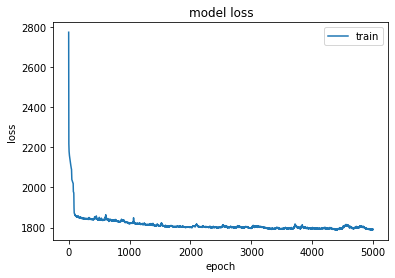

INFO:tensorflow:Assets written to: ./Data/vae_model.hf5/assets


INFO:tensorflow:Assets written to: ./Data/vae_model.hf5/assets


In [20]:
opt = RMSprop(learning_rate=0.0001)
opt = Adam(learning_rate=0.00001, clipvalue=0.5)
opt = Adam()


vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

trained = False     # First time train / Next times use saved model to speed up analysis
if trained:
    vae_model = load_model('./Data/vae_model.hf5', custom_objects={'vae_loss': vae_loss})

else:
    results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=5000,
                        batch_size=128)
    # Training figure
    plt.plot(results.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    # saving weights
    vae_model.save('./Data/vae_model.hf5')

In [21]:
X_train_pred = vae_model.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
mae_vector_train = get_error_term(X_train_pred, X_train, _rmse=False)

print(f'Avg error {np.mean(mae_vector_train)}\nmedian error {np.median(mae_vector_train)}\n99Q:    \
      {np.quantile(mae_vector_train, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector_train, 0.99)} ')

error_thresh = np.quantile(mae_vector_train, 0.99)
error_thresh = np.quantile(mae_vector_train, 0.995)
error_median = np.quantile(mae_vector_train, 0.5)
print(error_thresh, error_median)

Avg error 0.560516964870704
median error 0.504348283798191
99Q:          1.1524831629877428
setting threshold on 1.1524831629877428 
1.2088236263699634 0.504348283798191


<AxesSubplot:title={'center':'Distribution Plot reconstruction error ignitions'}, ylabel='Count'>

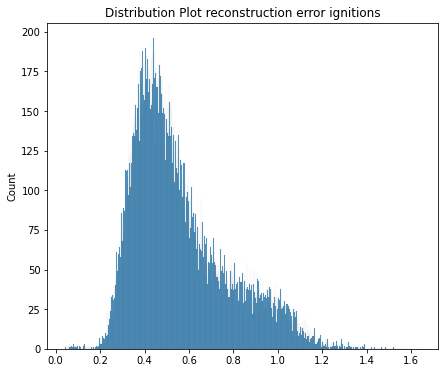

In [33]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title('Distribution Plot reconstruction error ignitions')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,50)
sns.histplot(data=mae_vector_train, bins = 1000)

In [24]:
X_pred_test = vae_model.predict(X_test)
print('threshold', error_thresh,error_median)
#train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

mae_vector = get_error_term(X_pred_test, X_test, _rmse=False)
anomalies = (mae_vector > error_median)

np.count_nonzero(anomalies) / len(anomalies)
print('total non_ignitions',len(X_pred_test))
print('number of almost_ignitions', np.count_nonzero(anomalies==0))

#print('total y_test',len(y_test))
#print(np.count_nonzero(y_test))

threshold 1.2088236263699634 0.504348283798191
total non_ignitions 1000000
number of almost_ignitions 509664


In [25]:
mae_vector

array([0.53714147, 0.49513051, 0.51034311, ..., 0.98492106, 0.60029889,
       0.62236139])

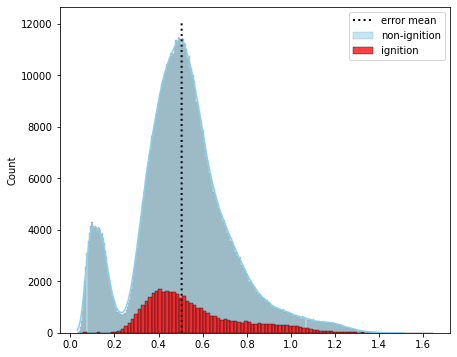

In [39]:
fig,ax1  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax1, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax1, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_median
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=2, estimator = None, 
             linestyle='dotted', label='error mean')
ax.set_title('Comparison reconstruction error ignition / non-ignition')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [54]:
error_thresh_low = np.quantile(mae_vector_train, 0.33)
error_thresh_high = np.quantile(mae_vector_train, 0.66)
print(error_thresh_low,error_thresh_high)
near_ignitions = (mae_vector > error_thresh_low )
near_ignitions = ((mae_vector > error_thresh_low) &(mae_vector < error_thresh_high))
near_ignitions = near_ignitions*1 # trick to have near_ignitions as 1 and ignitions as 0

0.43324426599306093 0.5938274161206691


In [55]:
near_ignitions

array([1, 1, 1, ..., 0, 0, 0])

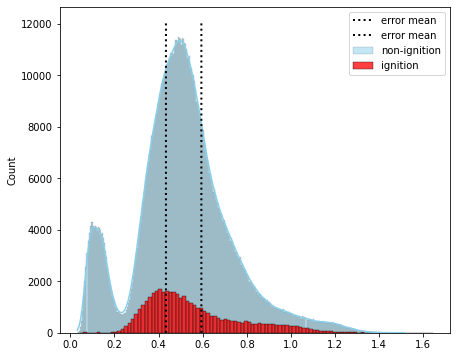

In [38]:
fig,ax1  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax1, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax1, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_thresh_low
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=2, estimator = None, 
             linestyle = 'dotted', label='error mean')
linex = np.ones(len(liney))* error_thresh_high
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=2, estimator = None, 
             linestyle = 'dotted', label='error mean')
ax.set_title('Comparison reconstruction error ignition / non-ignition')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [57]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = vae_model.predict(X_test)
# PCA transformation to observe variance in 2 components

pca = PCA(n_components=3)
X_transform = pca.fit_transform(X_pred2)

/home/manero/DL/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


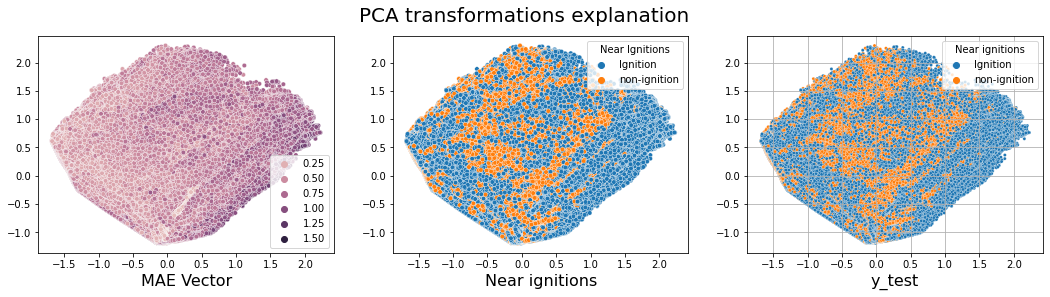

In [58]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations explanation',size=20)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=near_ignitions, ax=ax2)
ax2.set_xlabel('Near ignitions', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Ignition', 'non-ignition'], title='Near Ignitions')

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=near_ignitions, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Ignition', 'non-ignition'], title='Near ignitions')

plt.grid()
plt.show()

In [59]:
#===== program ends here. now create a new label and label non-ignition dataset with new class ===== #

In [32]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-45-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-06-25 10:48


### 